<a href="https://colab.research.google.com/github/OMER62/Search-Engine-Project/blob/main/Search_engine_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step A: Install PYSPARK


In [ ]:
import sys
from collections import Counter, OrderedDict
import itertools
from itertools import islice, count, groupby
import pandas as pd
import os
import re
from operator import itemgetter
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
from time import time
from timeit import timeit
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from google.cloud import storage

import hashlib
def _hash(s):
    return hashlib.blake2b(bytes(s, encoding='utf8'), digest_size=5).hexdigest()

nltk.download('stopwords')

from inverted_index_colab import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **Importe the Index And Create A New Folder To save the Text_Index_Files:**

*   List item
*   List item



In [ ]:
from inverted_index_colab import *
!mkdir Index_Text

In [ ]:
# These will already be installed in the testing environment so disregard the 
# amount of time (~1 minute) it takes to install. 
!pip install -q pyspark
!pip install -U -q PyDrive
#Addition:
!apt-get update -qq
!apt install openjdk-8-jdk-headless -qq
!pip install -q graphframes
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
graphframes_jar = 'https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar'
spark_jars = '/usr/local/lib/python3.7/dist-packages/pyspark/jars'
!wget -N -P $spark_jars $graphframes_jar

In [ ]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from graphframes import *

In [ ]:
# Initializing spark context
# create a spark context and session
conf = SparkConf().set("spark.ui.port", "4050")
sc = pyspark.SparkContext(conf=conf)
sc.addPyFile(str(Path(spark_jars) / Path(graphframes_jar).name))
spark = SparkSession.builder.getOrCreate()

#Step B: Working with the Wikidata


In [ ]:
# Copy one wikidumps files 
import os
from pathlib import Path
from google.colab import auth

project_id = 'core-period-321814'
!gcloud config set project {project_id}

data_bucket_name = 'wikidata_preprocessed'
try:
    if os.environ["wikidata_preprocessed"] is not None:
        pass  
except:
      !mkdir wikidumps
      !gsutil cp gs://{data_bucket_name}/multistream1_preprocessed.parquet "wikidumps/"
print() 

In [ ]:
# Authenticate your user
# The authentication should be done with the email connected to your GCP account
from google.colab import auth
auth.authenticate_user()

In [ ]:
from pathlib import Path 
import os

try:
    if os.environ["wikidata_preprocessed"] is not None:
      path = os.environ["wikidata_preprocessed"]+"/wikidumps/*"
except:
      path = "wikidumps/*"

parquetFile = spark.read.parquet(path)
parquetFile.show()

+---+--------------------+--------------------+--------------------+
| id|               title|                text|         anchor_text|
+---+--------------------+--------------------+--------------------+
| 12|           Anarchism|'''Anarchism''' i...|[{23040, politica...|
| 25|              Autism|'''Autism''' is a...|[{492271, Clinica...|
| 39|              Albedo|thumb|upright=1.3...|[{679294, diffuse...|
|290|                   A|'''A''', or '''a'...|[{290, See below}...|
|303|             Alabama|'''Alabama''' () ...|[{351590, Yellowh...|
|305|            Achilles|thumb|260px|Ancie...|[{1076007, potter...|
|307|     Abraham Lincoln|'''Abraham Lincol...|[{1827174, Alexan...|
|308|           Aristotle|'''Aristotle''' (...|[{1389981, bust},...|
|309|An American in Paris|'''''An American ...|[{13066, George G...|
|316|Academy Award for...|The '''Academy Aw...|[{39842, Academy ...|
|324|      Academy Awards|The '''Academy Aw...|[{649481, film in...|
|330|             Actrius|'''''Act

In [ ]:
parquetFile.count()

21084

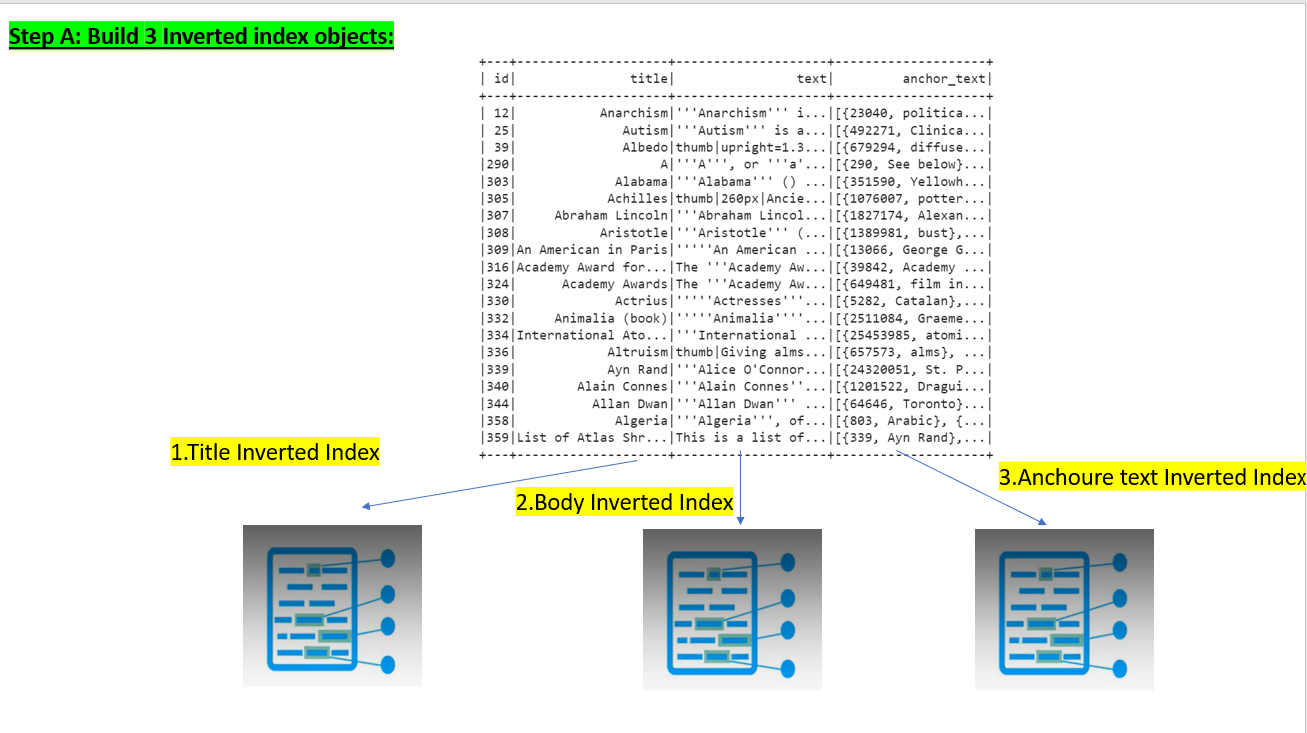

In [ ]:
# take the 'text' and 'id' of the first 1000 rows and create an RDD from it
#doc_text_pairs = parquetFile.limit(1000).select("text", "id").rdd
doc_text_pairs = parquetFile.select("text", "id").rdd

#Step C: Build our Text Invrted Index Baised on 5 methods:
      

1.   **Word_Count**:(text, id)

       *Input*:
              
    *   text(str):Text of one document
    *   id (int):Document id

    Output:

    * A list of (token, (doc_id, tf)) pairs 

      (tf: The occurrence number of a term in a specific document)

      for example: [("Anarchism", (12, 5)), ...]

2.   **def Calculate_Doc_len(text):**

       *Input*:
              
    * length(int):the number of terms in each document 

    *Output:*

    *     list of tuples
      A sorted posting list.



3.   **def reduce_word_counts(unsorted_pl):**

       *Input*:
              
    * unsorted_pl: list of tuples
      A list of (wiki_id, tf) tuples 

    *Output:*

    *     list of tuples
      A sorted posting list.

4.   **def calculate_df(postings):**

       *Input*:
              
    *  postings: RDD
      An RDD where each element is a (token, posting_list) pair.

    *Output:*

    *     RDD:
      An RDD where each element is a (token, df) pair.
5.   **def partition_postings_and_write(postings):**

       *Input*:
              
    *    postings: RDD
      An RDD where each item is a (w, posting_list) pair.

    *Output:*

    *     RDD:
            An RDD where each item is a posting locations dictionary for a bucket. The
      posting locations maintain a list for each word of file locations and 
      offsets its posting list was written to. See `write_a_posting_list` for 
      more details.





In [ ]:
#First a general methods:

#All the Stopwords:
english_stopwords = frozenset(stopwords.words('english'))
corpus_stopwords = ['category', 'references', 'also', 'links', 'extenal', 'see', 'thumb']
RE_WORD = re.compile(r"""[\#\@\w](['\-]?\w){2,24}""", re.UNICODE)


#Functon for the writing to bucket:
all_stopwords = english_stopwords.union(corpus_stopwords)
NUM_BUCKETS = 124
def token2bucket_id(token):
  return int(_hash(token),16) % NUM_BUCKETS

1.   **Word_Count**:(text, id)

In [ ]:
def word_count(text, id):
  ''' Count the frequency of each word in `text` (tf) that is not included in 
  `all_stopwords` and return entries that will go into our posting lists. 
  Parameters:
  -----------
    text: str
      Text of one document
    id: int
      Document id
  Returns:
  --------
    List of tuples
      A list of (token, (doc_id, tf)) pairs 
      for example: [("Anarchism", (12, 5)), ...]
  '''
  tokens = [token.group() for token in RE_WORD.finditer(text.lower())]
  #***Step A:remove `all_stopwords`
  tokens=[word for word in tokens if word not in all_stopwords]
  Output=[]
  w2cnt = Counter(tokens)
  for w, cnt in w2cnt.items():
    Output.append((w,(id,cnt)))
  return Output



# Example:
 **Input**

*   text = "This is a test to check the words count function actually count words" 

*   id = 0


**Output**:


[('test', (0, 1)), ('check', (0, 1)), ('words', (0, 2)), ('count', (0, 2)), ('function', (0, 1)), ('actually', (0, 1))]


After `flatMap` is executed, the counts for a given token are likely to be scattered accross multiple machines/workers in the cluster. In order to create the posting lists for each token, we need a reduce operation that collects them into one list and sorts them by the document id (wiki_id). 

Spark has several ways of reducing or aggergating values, but we will use `groupByKey`, which like Reduce in MapReduce, collects all the values for a given key into an iterable list of the values associated with that key. The result of `groupByKey` is an RDD with (key, value*s*) pairs. Then, we can call `map` to execute a function on each pair in that RDD or call `mapValues` to execute a function only on the values iterable.


In [ ]:
word_counts = doc_text_pairs.flatMap(lambda x: word_count(x[0], x[1]))

2.   **def Calculate_Doc_len(text):**

In [ ]:
def Calculate_Doc_len(text):
    tokens = [token.group() for token in RE_WORD.finditer(text.lower())]
    # YOUR CODE HERE
    #***Step A:remove `all_stopwords`
    tokens=[word for word in tokens if word not in all_stopwords]
    return len(tokens)

In [ ]:
Docs_Len=doc_text_pairs.map(lambda x:(x[1],Calculate_Doc_len(x[0])))

**Write the doc Lengths to the disk**

In [ ]:
df = Docs_Len.toDF()
df.coalesce(1).write.format('com.databricks.spark.csv').option("codec", "org.apache.hadoop.io.compress.GzipCodec").save('/content/All_Doc_len')

3.   **def reduce_word_counts(unsorted_pl):**

In [ ]:
def reduce_word_counts(unsorted_pl):
  ''' Returns a sorted posting list by wiki_id.
  Parameters:
  -----------
    unsorted_pl: list of tuples
      A list of (wiki_id, tf) tuples 
  Returns:
  --------
    list of tuples
      A sorted posting list.
  '''
  #Need to sort the list
  return sorted(unsorted_pl, key=itemgetter(0))

Next, we will filter out rare words, words that appear in 10 


or fewer documents (when working on the entire corpus, we will increase this threshold to a minimum of 50 documents).

# **Dont Must to Implimant it**

In [ ]:
#postings_filtered = postings.filter(lambda x: len(x[1])>10)
postings_filtered=postings

In [ ]:
postings = word_counts.groupByKey().mapValues(reduce_word_counts)

4.   **def calculate_df(postings):**

In [ ]:
def calculate_df(postings):
  ''' Takes a posting list RDD and calculate the df for each token.
  Parameters:
  -----------
    postings: RDD
      An RDD where each element is a (token, posting_list) pair.
  Returns:
  --------
    RDD
      An RDD where each element is a (token, df) pair.
  '''
  Output=postings.map(lambda w:(w[0],len(w[1])))
  return Output

In [ ]:
# global statistics
w2df = calculate_df(postings_filtered)

In [ ]:
# collectAsMap collects the results to the master node's memory as a dictionary.
# we know it's not so big so this is okay.
w2df_dict = w2df.collectAsMap()
# test select words
#assert w2df_dict['first'] == 805
#assert w2df_dict['many'] == 670
#assert w2df_dict['used'] == 648

4.   **def partition_postings_and_write(postings):**


In [ ]:
NUM_BUCKETS = 124
def token2bucket_id(token):
  return int(_hash(token),16) % NUM_BUCKETS

def partition_postings_and_write(postings):
  ''' A function that partitions the posting lists into buckets, writes out 
  all posting lists in a bucket to disk, and returns the posting locations for 
  each bucket. Partitioning should be done through the use of `token2bucket` 
  above. Writing to disk should use the function  `write_a_posting_list`, a 
  static method implemented in inverted_index_colab.py under the InvertedIndex 
  class. 
  Parameters:
  -----------
    postings: RDD
      An RDD where each item is a (w, posting_list) pair.
  Returns:
  --------
    RDD
      An RDD where each item is a posting locations dictionary for a bucket. The
      posting locations maintain a list for each word of file locations and 
      offsets its posting list was written to. See `write_a_posting_list` for 
      more details.
  '''
  #***Step A:partitions the posting lists into buckets`
  Output=postings.map(lambda w:(token2bucket_id(w[0]),[w]))
  Output=Output.reduceByKey(lambda a, b: a+b)
  Output=Output.map(lambda Curent_posting_list:InvertedIndex.write_a_posting_list(Curent_posting_list))
  return Output
  

In [ ]:
posting_locs_list = partition_postings_and_write(postings_filtered).collect()
# merge the posting locations into a single dict 
super_posting_locs = defaultdict(list)
for posting_loc in posting_locs_list:
  for k, v in posting_loc.items():
    super_posting_locs[k].extend(v)

In [ ]:
# Create inverted index instance
inverted = InvertedIndex()
# Adding the posting locations dictionary to the inverted index
inverted.posting_locs = super_posting_locs
# Add the token - df dictionary to the inverted index
inverted.df = w2df_dict
# write the global stats out
inverted.write_index('Index_Text/.', 'index_text')

## Make The Files as Zip:

In [ ]:
!zip -r /content/Index_Text.zip /content/Index_Text